
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Classifier training and performance assessment. </h2>	

In [1]:
WORKING_DIR = '/content/drive/My Drive/computer_vision/'
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/My Drive/computer_vision"
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/computer_vision


In [2]:
!pip install featexp
!pip install mahotas

In [3]:
import sys
sys.path.append("./model_utils.py")

import pandas as pd
import sklearn
import numpy as np
import time
from model_utils import XGBoostModel, BOVWVectorizer, class_names
import matplotlib.pyplot as plt
import skimage
import json

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
def train_test_split(df):
    return df
#Split the data into a training set, and test set 
def accuracy(pred, actual):
    return np.sum(pred == actual) / pred.shape[0]
# Calculate the accuracy percentage of the predicted values

In [5]:
# Read training data
X_training = pd.read_pickle('X_training.pkl')
Y_training = pd.read_pickle('Y_training.pkl')
display(X_training.head())

# Read testing dataset and normalize
X_testing = pd.read_pickle('X_testing.pkl')
Y_testing = pd.read_pickle('Y_testing.pkl')
display(X_testing.head())

# Normalize training data and drop columns where standard deviation is close to 0
X_mean = np.mean(X_training,axis=0)
X_std = np.std(X_training,axis=0)
# Drop columns whose standard deviation is 0
columns_to_drop = X_std[X_std == 0].index.values
print("Columns to drop:", columns_to_drop)
X_training_standardized=((X_training-X_mean)/X_std).drop(columns=columns_to_drop)

# Read testing dataset and normalize the same way as training
X_testing_standardized=((X_testing-X_mean)/X_std).drop(columns=columns_to_drop)

,ft_size,ft_red_avg,ft_aspect_ratio,ft_green_avg,ft_blue_avg,ft_red_std,ft_green_std,ft_blue_std,ft_red_proportion,ft_green_proportion,ft_blue_proportion,ft_harris_avg,ft_harris_std,ft_corner_count,ft_color_histogram0,ft_color_histogram1,ft_color_histogram2,ft_color_histogram3,ft_color_histogram4,ft_color_histogram5,ft_color_histogram6,ft_color_histogram7,ft_color_histogram8,ft_color_histogram9,ft_color_histogram10,ft_color_histogram11,ft_color_histogram12,ft_color_histogram13,ft_color_histogram14,ft_color_histogram15,ft_color_histogram16,ft_color_histogram17,ft_color_histogram18,ft_color_histogram19,ft_color_histogram20,ft_color_histogram21,ft_color_histogram22,ft_color_histogram23,ft_color_histogram24,ft_color_histogram25,...,bovw_210,bovw_211,bovw_212,bovw_213,bovw_214,bovw_215,bovw_216,bovw_217,bovw_218,bovw_219,bovw_220,bovw_221,bovw_222,bovw_223,bovw_224,bovw_225,bovw_226,bovw_227,bovw_228,bovw_229,bovw_230,bovw_231,bovw_232,bovw_233,bovw_234,bovw_235,bovw_236,bovw_237,bovw_238,bovw_239,bovw_240,bovw_241,bovw_242,bovw_243,bovw_244,bovw_245,bovw_246,bovw_247,bovw_248,bovw_249
0,284616,185.914495,1.703390,191.596003,179.248767,4553.214440,4820.877852,5265.418035,0.056560,0.885973,0.009929,-0.000068,0.001920,10,0.006346,0.012375,0.018403,0.994740,0.021259,0.031413,0.000635,0.000000,0.041884,0.008567,0.000000,0.000000,0.067268,0.000952,0.000000,0.000000,0.001904,0.010788,0.003808,0.041249,0.003490,0.005077,0.000000,0.000000,0.003490,0.000000,...,0,0,2,0,1,0,0,0,0,0,0,0,0,2,0,0,1,1,2,0,2,1,2,0,0,0,0,0,2,3,2,0,0,2,0,0,0,1,0,1
1,206100,125.856492,1.310044,119.466317,117.436419,1181.955839,899.225780,685.420688,0.572431,0.044585,0.352271,0.000015,0.000235,20,0.000000,0.305097,0.631127,0.092628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.459477,0.024596,0.007327,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,2,2,1,2,2,0,0,2,2,3,5,1,0,0,1,0,1,5,0,1,4,1,2,0,0,1,1,2,1,4,1,2,2,2,0,1,1,1
2,443520,128.859274,1.309524,135.447281,135.748593,4813.070544,5312.015308,5552.734819,0.042160,0.377834,0.455837,0.000003,0.000541,24,0.221246,0.252330,0.145669,0.064606,0.038398,0.003657,0.000000,0.000000,0.006095,0.000609,0.000000,0.000000,0.004266,0.000000,0.000000,0.000000,0.156640,0.322422,0.450415,0.725297,0.046931,0.001219,0.000000,0.000000,0.010361,0.000000,...,4,0,8,2,0,2,3,0,2,4,2,5,4,4,2,1,1,1,2,3,11,1,1,0,3,0,2,0,3,1,2,2,3,3,3,8,6,2,1,0
3,195804,94.103619,0.755102,97.141065,117.901912,3681.097111,3947.707946,5215.216309,0.085892,0.210440,0.660737,0.000146,0.001133,21,0.151590,0.085727,0.047045,0.152635,0.158908,0.140090,0.062727,0.013591,0.078408,0.095136,0.049136,0.015682,0.036591,0.041818,0.035545,0.006273,0.178771,0.087817,0.080499,0.311543,0.169362,0.280179,0.565586,0.280179,0.031363,0.231043,...,1,4,2,4,6,1,2,1,6,2,11,8,7,4,2,4,4,3,0,0,2,2,0,0,1,2,0,2,4,0,1,1,4,3,3,3,1,1,4,1
4,1078410,120.672738,1.355340,97.604190,104.655813,1879.427155,1370.837781,1078.084192,0.608042,0.000643,0.384922,0.000009,0.000251,22,0.001993,0.006643,0.116915,0.033879,0.001329,0.092336,0.658973,0.043179,0.000000,0.003986,0.020593,0.003986,0.000000,0.000000,0.000000,0.000000,0.002657,0.033879,0.067093,0.056464,0.025243,0.178029,0.049822,0.000664,0.000000,0.000664,...,1,0,1,1,0,0,2,0,1,0,0,0,0,4,1,0,0,0,0,0,0,1,3,0,0,0,0,0,3,1,3,2,0,0,1,0,1,2,0,1


,ft_size,ft_red_avg,ft_aspect_ratio,ft_green_avg,ft_blue_avg,ft_red_std,ft_green_std,ft_blue_std,ft_red_proportion,ft_green_proportion,ft_blue_proportion,ft_harris_avg,ft_harris_std,ft_corner_count,ft_color_histogram0,ft_color_histogram1,ft_color_histogram2,ft_color_histogram3,ft_color_histogram4,ft_color_histogram5,ft_color_histogram6,ft_color_histogram7,ft_color_histogram8,ft_color_histogram9,ft_color_histogram10,ft_color_histogram11,ft_color_histogram12,ft_color_histogram13,ft_color_histogram14,ft_color_histogram15,ft_color_histogram16,ft_color_histogram17,ft_color_histogram18,ft_color_histogram19,ft_color_histogram20,ft_color_histogram21,ft_color_histogram22,ft_color_histogram23,ft_color_histogram24,ft_color_histogram25,...,bovw_210,bovw_211,bovw_212,bovw_213,bovw_214,bovw_215,bovw_216,bovw_217,bovw_218,bovw_219,bovw_220,bovw_221,bovw_222,bovw_223,bovw_224,bovw_225,bovw_226,bovw_227,bovw_228,bovw_229,bovw_230,bovw_231,bovw_232,bovw_233,bovw_234,bovw_235,bovw_236,bovw_237,bovw_238,bovw_239,bovw_240,bovw_241,bovw_242,bovw_243,bovw_244,bovw_245,bovw_246,bovw_247,bovw_248,bovw_249
0,451584,149.040444,1.333333,110.549918,105.396637,4573.374653,5745.490838,5047.090852,0.919417,0.004451,0.065503,0.000006,0.001558,21,0.055136,0.289045,0.242263,0.157889,0.129485,0.045946,0.023391,0.627378,0.076020,0.091893,0.011695,0.000835,0.050123,0.088551,0.104424,0.000835,0.030074,0.008354,0.016708,0.024226,0.003342,0.000000,0.000000,0.000000,0.005848,0.000835,...,1,0,1,0,0,2,0,1,0,0,4,0,1,1,1,2,0,4,1,0,1,1,0,1,0,1,0,0,7,0,6,0,0,0,0,5,0,0,0,0
1,138996,82.377061,1.181818,108.411508,62.205474,6150.428834,8183.128684,4494.952471,0.028641,0.856449,0.068376,0.000290,0.003561,26,0.117664,0.053082,0.068122,0.265409,0.131820,0.185786,0.169861,0.504276,0.251253,0.240637,0.234444,0.205249,0.541434,0.120319,0.046004,0.006193,0.015040,0.007962,0.005308,0.016809,0.055736,0.002654,0.000000,0.000000,0.114126,0.000885,...,6,1,3,1,4,2,5,4,3,5,7,3,8,5,2,3,3,5,10,2,4,4,5,2,11,3,9,0,3,3,2,2,2,8,3,1,2,6,1,5
2,275100,154.227808,1.335878,140.715573,132.038986,2434.700165,4649.553430,4781.235677,0.326325,0.593217,0.047350,0.000089,0.001097,22,0.042090,0.211926,0.488095,0.228171,0.002215,0.031752,0.049474,0.011815,0.002954,0.121839,0.310136,0.010338,0.005907,0.127008,0.084180,0.003692,0.031014,0.141776,0.432713,0.560459,0.002215,0.001477,0.000738,0.000738,0.000000,0.002954,...,1,0,3,0,0,5,1,3,0,0,1,1,3,2,1,1,1,1,13,2,0,0,6,0,1,1,1,0,6,7,6,1,2,0,1,4,1,1,2,3
3,631890,12.574999,1.680791,11.876599,17.020624,939.306921,865.822620,1823.085507,0.126663,0.006746,0.149964,0.000007,0.000358,11,0.997040,0.000911,0.001215,0.002430,0.007291,0.002127,0.000304,0.000608,0.002430,0.000911,0.000608,0.000000,0.011544,0.000911,0.000304,0.000000,0.001519,0.002734,0.000000,0.002430,0.011848,0.039493,0.020658,0.010025,0.027341,0.011848,...,0,0,0,0,0,0,0,0,0,0,5,0,1,0,0,2,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0
4,216900,179.351521,1.244813,173.675574,167.268866,1108.435810,1661.895135,2489.338015,0.279876,0.019530,0.034952,-0.000008,0.000454,12,0.000677,0.009137,0.038915,0.988780,0.005753,0.064971,0.092719,0.019965,0.004737,0.059219,0.019288,0.000000,0.000000,0.001015,0.000000,0.000000,0.000000,0.000000,0.004061,0.056850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,1,1,0,0,0,2,0,0,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,0,0,2,0,10,1,0,1,0,1,0,0,0,0


Columns to drop: ['ft_color_histogram48' 'ft_color_histogram49' 'ft_color_histogram50'
 'ft_color_histogram51' 'ft_color_histogram52' 'ft_color_histogram53'
 'ft_color_histogram54' 'ft_color_histogram55' 'ft_color_histogram56'
 'ft_color_histogram57' 'ft_color_histogram58' 'ft_color_histogram59'
 'ft_color_histogram60' 'ft_color_histogram61' 'ft_color_histogram62'
 'ft_color_histogram63']


<h3>  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding</h3>	Take note of the differences in accuracy, and methods. Note that the accuracy may be different from the report due to randomness. We selected the result of our first run with the final parameters for our report.


In [6]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

def mse_cost(y_pred, y_actual):
    return np.mean((y_pred - y_actual) ** 2)

@ignore_warnings(category=ConvergenceWarning)   
def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=5)
    training_errors = []
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train,split_Y_train)
        
        training_error = 1 - accuracy_score(split_Y_train,model.predict(split_X_train))
        validation_error = 1 - accuracy_score(split_Y_valid,model.predict(split_X_valid))

        training_errors.append(training_error)
        validation_errors.append(validation_error)
    
    #average validation errors
    return np.mean(training_errors), np.mean(validation_errors)

## Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

lr_model_search_params = {'C': [0.01, 0.02, 0.05, 0.08] + np.linspace(0.1, 10, 20).tolist()}
lr_clf = GridSearchCV(LogisticRegression(max_iter=1000), lr_model_search_params).fit(X_training_standardized, Y_training)
lr_model = lr_clf.best_estimator_
print(f'Best parameters: {lr_clf.best_params_}')
# lr_model = LogisticRegression(max_iter=1000)
training_misclassification_rate, validation_misclassification_rate = compute_CV_error(lr_model, X_training_standardized, Y_training)
print(f'Training misclassification rate: {training_misclassification_rate}, validation misclassification rate: {validation_misclassification_rate}.')

# testing errors
lr_test_misclassification_rate = 1 - accuracy_score(Y_testing, lr_model.predict(X_testing_standardized))
print(f'Testing misclassification rate: {lr_test_misclassification_rate}.')

Best parameters: {'C': 0.01}
Training misclassification rate: 0.1759788842544317, validation misclassification rate: 0.5154253835425383.
Testing misclassification rate: 0.5647840531561461.


## K-nearest Neighbors

In [8]:
from sklearn.neighbors import KNeighborsClassifier
# Select k that minimizes the validation misclassification rate
# best_k, best_training_misclassification_rate, best_validation_misclassification_rate, best_knn_model = -1., 1., 1., None
knn_search_params = {'n_neighbors': list(range(5,20))}
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_search_params).fit(X_training_standardized, Y_training)
knn_model = knn_clf.best_estimator_
print(f'Best parameters: {knn_clf.best_params_}')
training_misclassification_rate, validation_misclassification_rate = compute_CV_error(knn_model, X_training_standardized, Y_training)
print(f'Training misclassification rate: {training_misclassification_rate}, validation misclassification rate: {validation_misclassification_rate}.')

# testing errors
knn_test_misclassification_rate = 1 - accuracy_score(Y_testing, knn_model.predict(X_testing_standardized))
print(f'Testing misclassification rate {knn_test_misclassification_rate}')

Best parameters: {'n_neighbors': 18}
Training misclassification rate: 0.5381591067083769, validation misclassification rate: 0.6263598326359833.
Testing misclassification rate 0.6411960132890365


## Classification Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()
training_misclassification_rate, validation_misclassification_rate = compute_CV_error(tree_model, X_training_standardized, Y_training)
print(f'Training misclassification rate: {training_misclassification_rate}, validation misclassification rate: {validation_misclassification_rate}.')

tree_test_misclassification_rate = 1 - accuracy_score(Y_testing, tree_model.predict(X_testing_standardized))
print(f'Testing misclassification rate {tree_test_misclassification_rate}')

Training misclassification rate: 0.0, validation misclassification rate: 0.6838981868898186.
Testing misclassification rate 0.7043189368770764


## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

# fit the model using grid search

rf_search_params = {
    'max_depth': [2, 3, 4, 5, 6, 8, 12, 15, 20],
    'n_estimators': [50, 100, 200, 300, 500, 1000]
}

rf_model = RandomForestClassifier(n_jobs=1)

rf_clf = GridSearchCV(rf_model, rf_search_params, n_jobs=2, verbose=True)
rf_clf.fit(X_training_standardized, Y_training)
rf_model = rf_clf.best_estimator_

training_error, validation_error = compute_CV_error(rf_model, X_training_standardized, Y_training)
print(f'Training misclassification rate: {training_error}, validation misclassification rate: {validation_error}')

rf_test_misclassification_rate = 1 - accuracy_score(Y_testing, rf_model.predict(X_testing_standardized))
print(f'Testing misclassification rate {rf_test_misclassification_rate}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 270 out of 270 | elapsed:  7.7min finished


Training misclassification rate: 0.0, validation misclassification rate: 0.5437691771269177
Testing misclassification rate 0.6013289036544851


## Support Vector Machine

In [11]:
from sklearn.svm import SVC, LinearSVC

svc_model = SVC(C=3, kernel='rbf', max_iter=3000)

training_error_rate, validation_error_rate = compute_CV_error(svc_model, X_training_standardized, Y_training)
print("SVC Model Results")
print("Training Error: {0}  Validation Error: {1}".format(training_error_rate, validation_error_rate))

svc_testing_misclassification_rate = 1 - accuracy_score(Y_testing, svc_model.predict(X_testing_standardized))
print(f'SVC Testing misclassification rate {svc_testing_misclassification_rate}')

SVC Model Results
Training Error: 0.006671228710462285  Validation Error: 0.537112970711297
SVC Testing misclassification rate 0.5714285714285714


## Gradient Boosted Trees (Extra)

In [12]:
xgb_model = XGBoostModel(columns=X_training_standardized.columns.to_list())

training_error, validation_error = xgb_model.cv_error(X_training_standardized, Y_training)
print("gradient boosting : {0}  Validation Error: {1}".format(training_error, validation_error))

xgb_test_misclassification_rate = 1 - accuracy_score(Y_testing, xgb_model.predict(X_testing_standardized))
print(f'Test misclassification rate {xgb_test_misclassification_rate}')

gradient boosting : 0.0  Validation Error: 0.10583333333333333
Test misclassification rate 0.5647840531561461


The Gain is the most relevant attribute to interpret the relative importance of each feature. The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

In [13]:
gains = xgb_model.bst.get_score(importance_type='gain')
gains = [(k,gains[k]) for k in gains]
gains.sort(key=lambda x:x[1],reverse=True)
for feature, score in gains:
    print(feature, score)

ft_color_histogram47 17.9642887
ft_color_histogram30 13.864474422
bovw_108 13.288239951000001
bovw_205 7.840936650600952
ft_green_avg 5.010090862364196
ft_size 4.458665313759143
bovw_101 4.306199887825
bovw_228 3.481206763983076
bovw_78 3.4002683236115385
ft_color_histogram43 3.2664088589999998
ft_aspect_ratio 3.0990759880777548
bovw_149 2.8652443839830006
bovw_126 2.686603046295001
ft_color_histogram16 2.3874003388080944
bovw_12 2.2969257242234997
ft_color_histogram45 2.204692716
bovw_184 2.1597135654186363
ft_color_histogram28 2.133917659499
bovw_24 2.077732457724445
ft_color_histogram6 2.067167716942779
ft_color_histogram46 2.053470851
bovw_10 2.0172461838575
ft_haralick5 2.00129171298375
ft_color_histogram26 1.9549143400152633
bovw_80 1.9443475179599998
bovw_14 1.8955730551999994
bovw_231 1.7660643720840004
ft_blue_proportion 1.7267315368296927
bovw_241 1.6892375859833333
bovw_38 1.6143516264
bovw_176 1.5770020296444445
bovw_100 1.5249269136333332
ft_color_histogram10 1.50317793629

## Prediction

We select Gradient Boosted Trees as our final model. Now, let's compute the prediction.

In [14]:
# re-train the model on the entire dataset
X_labeled_standardized = pd.concat((X_training_standardized, X_testing_standardized))
Y_labeled = pd.concat((Y_training, Y_testing))
xgb_model = XGBoostModel(columns=X_training_standardized.columns.to_list())
xgb_model.train(X_labeled_standardized, Y_labeled)

In [15]:
X_unlabeled = pd.read_pickle('X_unlabeled.pkl')
X_unlabeled_standardized=((X_unlabeled-X_mean)/X_std).drop(columns=columns_to_drop)
prediction = pd.DataFrame(map(int,xgb_model.predict(X_unlabeled_standardized)))

In [16]:
# prediction.to_csv('prediction.csv',header=False,index=False)

Now let's check some random images.

In [17]:
unlabeled_data = pd.read_pickle('unlabeled_data.pkl')

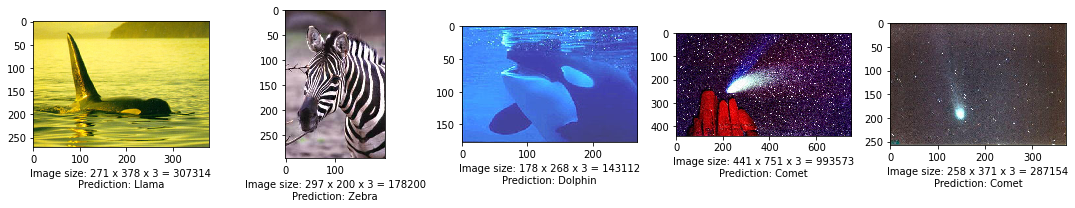

In [18]:
# Visualize 5 random results
samples = unlabeled_data.sample(n=5)
plt.figure(figsize=(15,3))
for i in range(5):
    pic = samples.iloc[i,0]
    fig = plt.subplot(1,5,i+1)
    fig.grid(False)
    skimage.io.imshow(pic)
    fig.set_xlabel(f'Image size: {pic.shape[0]} x {pic.shape[1]} x ' +
    f'{pic.shape[2]} = {pic.size}\n'+
    f'Prediction: {class_names[prediction.iloc[samples.index[i],0]]}')